### Imports

In [1]:
import os
import sys
# Set project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import pandas as pd

import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

#--- Get absolute path to the utils folder---
from pathlib import Path
utils_path = Path.cwd() / "utils"
sys.path.append(str(utils_path))

backtesting_path = Path.cwd() / "backtesting"
sys.path.append(str(backtesting_path))

from notebooks.utils.config_utils import load_config
from notebooks.utils.data_utils import load_dataset, preprocess_data
from notebooks.utils.model_utils import initialise_model, grid_search, get_feature_importance, optimise_threshold
from notebooks.utils.plotting_utils import plot_correlation, plot_scatter, plot_roc_and_prc, plot_classification_report, plot_point_biserial_correlation, plot_dataset_split
from notebooks.utils.pdf_utils import create_markdown_report, update_markdown_with_model_details, convert_markdown_to_html, save_pdf_from_html

from notebooks.backtesting.backtester import Backtester

### Load config.yaml

In [2]:
# Test load
config = load_config('config_trailing.yaml')

Config loaded successfully!


### Load the dataset

In [3]:
df = load_dataset(config)
df_selected, selected_features, constructed_features, target_variable = preprocess_data(df, config)

df_selected

📁 Dataset Loaded: 3639 rows, 101 columns
✅ Dataset Preprocessed: 3416 rows, 31 columns


,id_odsp,date,season,league,country,home_team,away_team,score_pre_80,score_ft,leading_team_corners_70_75,...,trailing_team_shot_to_corner_ratio_pre_80,leading_team_shot_to_corner_ratio_pre_80,trailing_team_aggression_score_pre_80,leading_team_aggression_score_pre_80,leading_team_urgency_to_attack,trailing_team_urgency_to_attack,leading_team_momentum_to_attack,trailing_team_momentum_to_attack,trailing_team_probability,target
0,Aw5DflLH/,2011-08-06,2012,D1,germany,FC Augsburg,SC Freiburg,1-2,2-2,0,...,2.250,2.667,1.556,3.125,0.294,0.424,-0.294,-0.424,42.373,1
1,CzPV312a/,2011-08-06,2012,F1,france,Paris Saint-Germain,Lorient,0-1,0-1,0,...,2.750,1.800,1.727,0.667,0.106,0.645,-0.106,1.935,64.516,1
2,GUOdmtII/,2011-08-06,2012,F1,france,Caen,Valenciennes,1-0,1-0,0,...,1.250,4.500,1.000,1.000,0.400,0.290,0.000,0.000,28.986,1
3,Wn69eU5B/,2011-08-06,2012,D1,germany,FC Cologne,VfL Wolfsburg,0-1,0-3,0,...,1.000,4.667,1.857,1.286,0.394,0.333,-0.788,0.333,33.333,0
4,bkjpaC6n/,2011-08-06,2012,D1,germany,Werder Bremen,Kaiserslautern,1-0,2-0,1,...,1.500,2.833,4.167,0.647,0.546,0.208,1.092,-0.208,20.833,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,r5V5rw33/,2017-01-22,2017,E0,england,Arsenal,Burnley,1-0,2-1,0,...,2.500,2.333,1.100,0.381,0.813,0.056,0.813,-0.224,5.634,0
3635,r5m8MY4G/,2017-01-22,2017,D1,germany,Bayer Leverkusen,Hertha Berlin,2-1,3-1,0,...,2.000,2.000,2.500,0.917,0.549,0.175,0.000,-0.175,17.544,0
3636,trUaUcuk/,2017-01-22,2017,SP1,spain,Osasuna,Sevilla,2-3,3-4,0,...,4.000,1.833,1.083,0.909,0.633,0.147,0.633,0.000,14.706,0
3637,xSU9scI9/,2017-01-22,2017,E0,england,Chelsea,Hull,1-0,2-0,0,...,1.143,0.875,1.500,1.571,0.840,0.050,0.000,0.050,5.000,0


### Plot correlation heatmap (for selected features)

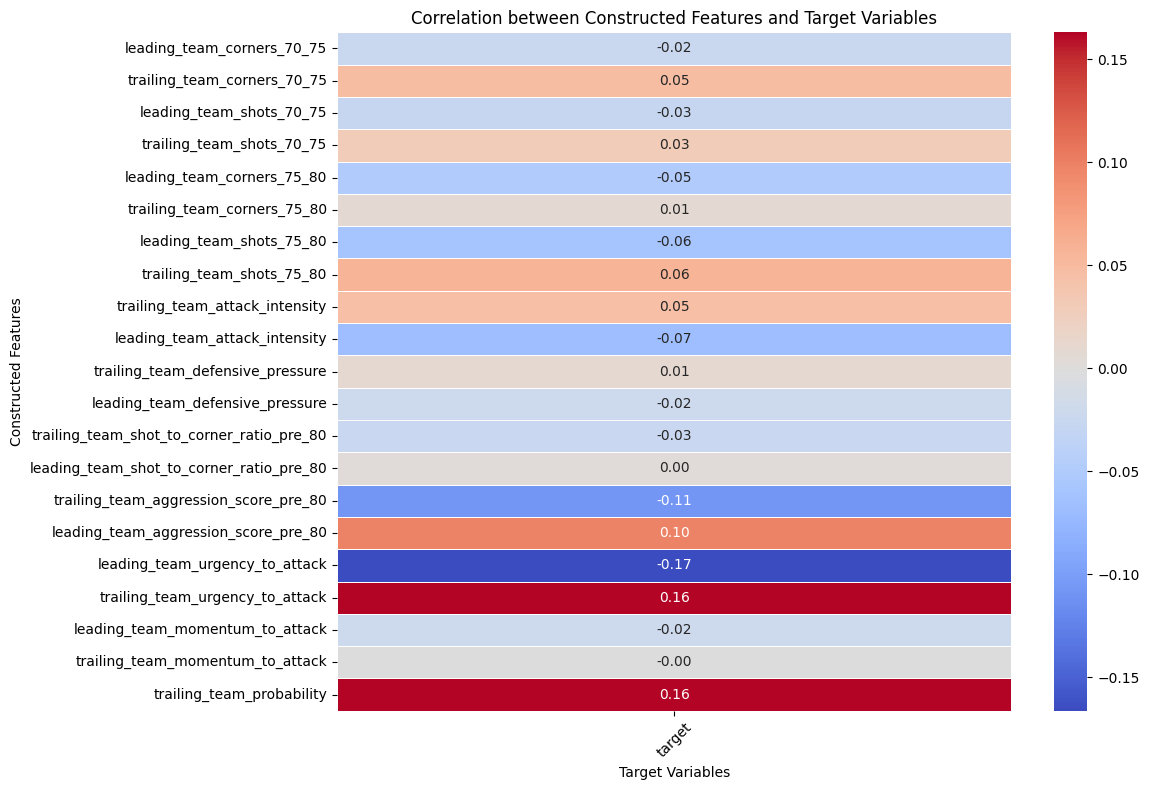

In [4]:
feature_correlation_image_path = plot_correlation(df_selected, selected_features, constructed_features, target_variable)

### Compute Point-Biserial Correlation and P-values

- **Point-biserial correlation**: Measures the strength and correlation between a binary variable (target) and continuous variables (each feature) (higher value better)
- **P-value**: Indicates if the correlation is statistically significant (lower value better)
- **Combined Score**: A reflective measure of both Point-biserial and P-val.

--- TOP 10 FEATURES ---
Feature
leading_team_urgency_to_attack           0.166161
trailing_team_urgency_to_attack          0.163106
trailing_team_probability                0.163093
trailing_team_aggression_score_pre_80    0.107705
leading_team_aggression_score_pre_80     0.098606
leading_team_attack_intensity            0.068087
leading_team_shots_75_80                 0.059550
trailing_team_shots_75_80                0.057241
leading_team_corners_75_80               0.049205
trailing_team_corners_70_75              0.047210
Name: Combined Score, dtype: float64
-----------------------


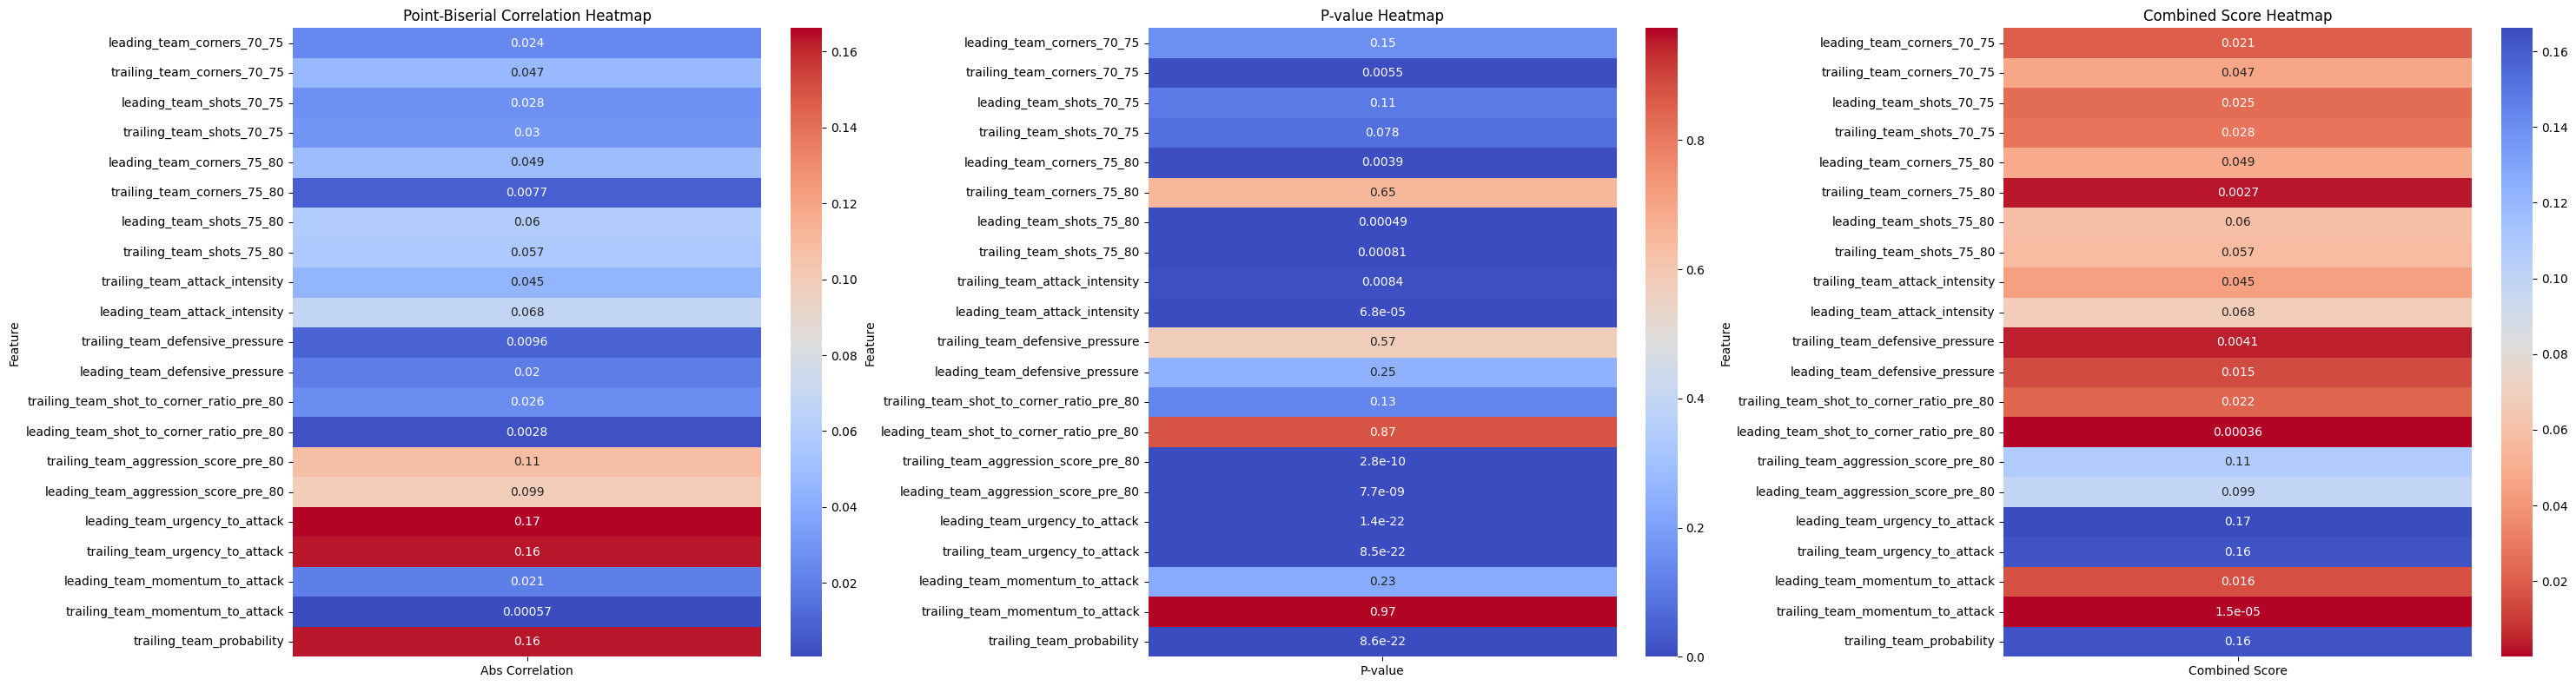

In [5]:
point_biserial_correlation_image_path = plot_point_biserial_correlation(df_selected, selected_features, constructed_features)

# Classification Pipeline

- **Feature Selection**: 
    - Trains only on selected and constructed features
- **Data Splitting**:
    - Exclude the last 500 rows for testing
    - Split remaining data into 80% train and 20% validation sets
- **Model Training Loop**:
    1) Initialise each model from config yaml
    2) Apply MinMax scaling... *only for models that require scaling*
    3) Perform grid search for hyperparameter tuning (if specified) and Train Model
    4) Predict on validation set and display feature importance
    5) Optimise precision-recall threshold
    6) Evaluate model on validation set using optimised threshold
    7) Plot ROC and Precision-Recall graphs
    8) Predict on the test set (last 500 rows) and evaluate
    9) Save the trained model
    10) Save predictions (for backtesting).
    11) Plot Scatter Graph.
    12) Backtesting called
    13) PDF Report generated.

In [6]:
def run_classification_pipeline(config, df, selected_features, constructed_features, target_variable, show_output=False, generate_pdf=False): 
    models_to_train = config['model']['classification']['models']
    
    # Step 1: Create the Markdown for the report
    if generate_pdf:
        markdown_content = create_markdown_report(config, feature_correlation_image_path, point_biserial_correlation_image_path, target_variable, selected_features, constructed_features, models_to_train)   
    #Only train on selected and constructed features
    X = df[selected_features + constructed_features]
    y = df[target_variable]

    #Get num of 1s and 0s
    value_counts=y.value_counts()
    num_ones=value_counts.get(1, 0)
    num_zeros=value_counts.get(0, 0)
    total=value_counts.sum()
    implied_1_plus_betting_odds = round(1/(num_ones/total), 4)

    print("--- DATASET STATS ---")
    print(f"Number of 1's: {num_ones}")
    print(f"Number of 0's: {num_zeros}")
    print(f"Total: {total}")
    print(f"Implied 1+ betting odds = {implied_1_plus_betting_odds}")
    print("---------------------")

    #Split data to exclude the last 500 rows for testing
    train_data = df.iloc[:-500]
    test_data = df.iloc[-500:]

    # Split data -> train & validation
    X_train, X_val, y_train, y_val = train_test_split(
        train_data[selected_features + constructed_features],
        train_data[target_variable],
        test_size=0.2,
        random_state=42,
        stratify=train_data[target_variable]
    )

    # Create X and y for testset
    X_test= test_data[selected_features+constructed_features]
    y_test =test_data[target_variable]

    # MinMax Scaling for models that require scaling...
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled =scaler.transform(X_val)
    X_test_scaled =scaler.transform(X_test)

    plot_dataset_split(train_data, X_val, y_val, test_data, target_variable, show_output, track_num=2)

    # --- MODEL TRAINING LOOP ---
    # Train and evaluate each model from the config
    models_to_train = config['model']['classification']['models']
    for model_name in models_to_train:
        print(f"\n-> Training {model_name}...")
    
        # Get the hyperparameters for the model
        hyperparameters = config["model"]["classification"]["hyperparameters"].get(model_name, {})
        do_grid_search=config["model"]["classification"].get("grid_search", False)

        # --- STEP 1: Initialise the model
        model = initialise_model(model_name, hyperparameters)

        # --- STEP 2: Select Scaled or Unscaled Data ---
        if model_name in ["logistic_regression", "svc", "xgboost"]:
            X_train, X_val, X_test = X_train_scaled, X_val_scaled, X_test_scaled
        
        # --- STEP 3: Grid Search (optional) ---
        if do_grid_search:
            optimal_model = grid_search(model_name, model, X_train, y_train, show_output)
        else:
            model.fit(X_train, y_train)
            optimal_model = model

        # --- STEP 4: Predict on the validation set ---
        y_pred_val = optimal_model.predict_proba(X_val)[:, 1]

        #Display Feature Importance
        feature_importances = get_feature_importance(optimal_model, model_name, selected_features, constructed_features)
        if show_output:
            print("\n### Top 8 and Bottom 5 Feature Importance ###")
            print(feature_importances)

        # --- STEP 5: Precision-Recall Threshold Optimisation ---
        best_threshold, optimal_threshold = optimise_threshold(y_pred_val, y_val, show_output)

        # optimal_threshold=0
        # --- STEP 6: Model Evaluation ---
        y_pred_threshold =(y_pred_val >= optimal_threshold).astype(int)
        if show_output:
            print(f"\n### Classification Report (threshold={optimal_threshold}):\n") 
            print(classification_report(y_val, y_pred_threshold))
        classification_report_str_1 = classification_report(y_val, y_pred_threshold, output_dict=False)

        # --- STEP 7: Plot ROC and Precision-Recall curves ---
        fpr,tpr,_ =roc_curve(y_val, y_pred_val)
        roc_auc =roc_auc_score(y_val, y_pred_val)
        precision,recall,_ =precision_recall_curve(y_val, y_pred_val)
        pr_auc=auc(recall, precision)

        # --- STEP 8: Test on test set (last 500 rows) ---
        # Predict on the final test data (last 500 rows)
        y_probs_final =optimal_model.predict_proba(X_test)[:, 1]
        y_pred_final=(y_probs_final >=optimal_threshold).astype(int)

        #Evaluate on the last 500 rows (final simulation)
        if show_output:
            print("\n### Prediction on last 500 rows: ###")
            print(classification_report(y_test, y_pred_final))
        classification_report_str_2 = classification_report(y_test, y_pred_final, output_dict=False)

        classification_report_image_path = plot_classification_report(optimal_model, X_val,y_val,X_test,y_test, model_name, show_output)
        roc_prc_image_path = plot_roc_and_prc(fpr, tpr, roc_auc,precision,recall, pr_auc,model_name,show_output)

        # --- STEP 9: Save Model ---
        model_dir = "../models" 
        if not os.path.exists(model_dir): # Ensure the directory exists
            os.makedirs(model_dir)
        # Save the model
        joblib.dump(optimal_model, os.path.join(model_dir, f"{model_name.replace(' ', '_').lower()}_model.pkl"))
        if show_output:
            print(f"{model_name} model saved.")

        prediction_file = f"../data/predictions/{model_name.replace(' ', '_').lower()}_predictions.csv"
        # --- STEP 10: Save Predictions ---
        results_df = pd.DataFrame({
            'kaggle_id': test_data['id_odsp'],
            'model_predicted_binary': y_pred_final,
            'actual_result': y_test
        })
        results_df.to_csv(prediction_file, index=False)
        if show_output:
            print(f"Predictions saved for {model_name}.")

        # --- STEP 11: Plot Scatter Graph ---
        scatter_image_path = plot_scatter(y_probs_final, y_test, model_name, show_output, optimal_threshold=optimal_threshold)

        # --- STEP 12: Backtesting called ---
        if show_output:
            print(f"\n-> Running Backtest for {model_name}...")
        odds_file = config["paths"]["total_corner_odds"]  # Ensure this exists in config.yaml
        backtester = Backtester(config, odds_file=odds_file, model_file=prediction_file, model_type="classification", target_mean=implied_1_plus_betting_odds)
        backtesting_image_path, backtesting_results_list = backtester.run(show_output)

        # --- STEP 13: PDF Report generated. ---
        if generate_pdf:
            #Finally, update markdown with generated outputs...
            markdown_content = update_markdown_with_model_details(
                markdown_content,
                model_name,
                feature_importances,
                best_threshold,
                classification_report_str_1,
                classification_report_str_2,
                classification_report_image_path,
                roc_prc_image_path,
                scatter_image_path,
                backtesting_results_list,
                backtesting_image_path
            )

    if generate_pdf:
        now = datetime.now()
        date_time_str = now.strftime("%Y-%m-%d, %H:%M")
        # Convert Markdown to html and save as pdf to reports/model_reports/
        html_content = convert_markdown_to_html(markdown_content)
        save_pdf_from_html(html_content, f'../reports/model_reports/{date_time_str}_model_report.pdf')
        print("📄 Saved PDF Report")
    
    print("✅ Finished Running Pipeline")

In [7]:
run_classification_pipeline(config, df_selected, selected_features, constructed_features, target_variable=target_variable[0], show_output=False, generate_pdf=True)

--- DATASET STATS ---
Number of 1's: 1954
Number of 0's: 1462
Total: 3416
Implied 1+ betting odds = 1.7482
---------------------

-> Training random_forest...

-> Training logistic_regression...

-> Training svc...

-> Training xgboost...
📄 Saved PDF Report
✅ Finished Running Pipeline
